In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18, 'figure.figsize': (25, 10), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

from jax_smolyak.indices import *

%load_ext autoreload
%autoreload 2

# Visualizing 2-D Multi-Index Sets

In [2]:
def print_indexset_sparse(t, k, d1, d2) :
    n1 = int(np.ceil(t/k(d1)))
    n2 = int(np.ceil(t/k(d2)))
    arr = [[' ' for _ in range(int(np.ceil(t/k(d2))))] for _ in range(n1)]
    i = indexset_sparse(k, t, cutoff=max(d1,d2)+1)
    arr[0][0] = 'x'
    for idx in i :
        if d1 in idx.keys() and d2 in idx.keys() :  arr[idx[d1]][idx[d2]] = 'x'
        if d1 in idx.keys() : arr[idx[d1]][0] = 'x'
        if d2 in idx.keys() : arr[0][idx[d2]] = 'x'

    for i in range(n1)[::-1]  :
        print('     +' + '---+'*len(arr[i]) + '\n {:3} | '.format(i), end='')
        for j in range(len(arr[i])) :
            print(arr[i][j] + ' | ', end='')
        print()
    print('     +' + '---+'*len(arr[-1]))
    print('       ', end='')
    for i in range(n2) : print(str(i) + '   ', end='')
    print()

In [3]:
def print_indexset_dense(t, k, d1, d2) :
    n1 = int(np.ceil(t/k[d1]))
    n2 = int(np.ceil(t/k[d2]))
    arr = [[' ' for _ in range(int(np.ceil(t/k[d2])))] for _ in range(n1)]
    i = indexset_dense(k, t)
    for idx in i :
        arr[idx[d1]][idx[d2]] = 'x'

    for i in range(n1)[::-1]  :
        print('     +' + '---+'*len(arr[i]) + '\n {:3} | '.format(i), end='')
        for j in range(len(arr[i])) :
            print(arr[i][j] + ' | ', end='')
        print()
    print('     +' + '---+'*len(arr[-1]))
    print('       ', end='')
    for i in range(n2) : print(str(i) + '   ', end='')
    print()

In [4]:
t = 6
print_indexset_sparse(t, lambda j : np.log(j+2)/np.log(2), 0, 1)
print_indexset_dense(t, [np.log(j+2)/np.log(2) for j in range(2)], 0, 1)

     +---+---+---+---+
   5 | x |   |   |   | 
     +---+---+---+---+
   4 | x | x |   |   | 
     +---+---+---+---+
   3 | x | x |   |   | 
     +---+---+---+---+
   2 | x | x | x |   | 
     +---+---+---+---+
   1 | x | x | x | x | 
     +---+---+---+---+
   0 | x | x | x | x | 
     +---+---+---+---+
       0   1   2   3   
     +---+---+---+---+
   5 | x |   |   |   | 
     +---+---+---+---+
   4 | x | x |   |   | 
     +---+---+---+---+
   3 | x | x |   |   | 
     +---+---+---+---+
   2 | x | x | x |   | 
     +---+---+---+---+
   1 | x | x | x | x | 
     +---+---+---+---+
   0 | x | x | x | x | 
     +---+---+---+---+
       0   1   2   3   


# Visualizing Admissible Weight Sequences For Constructing High-dimensional Multi-Index Sets

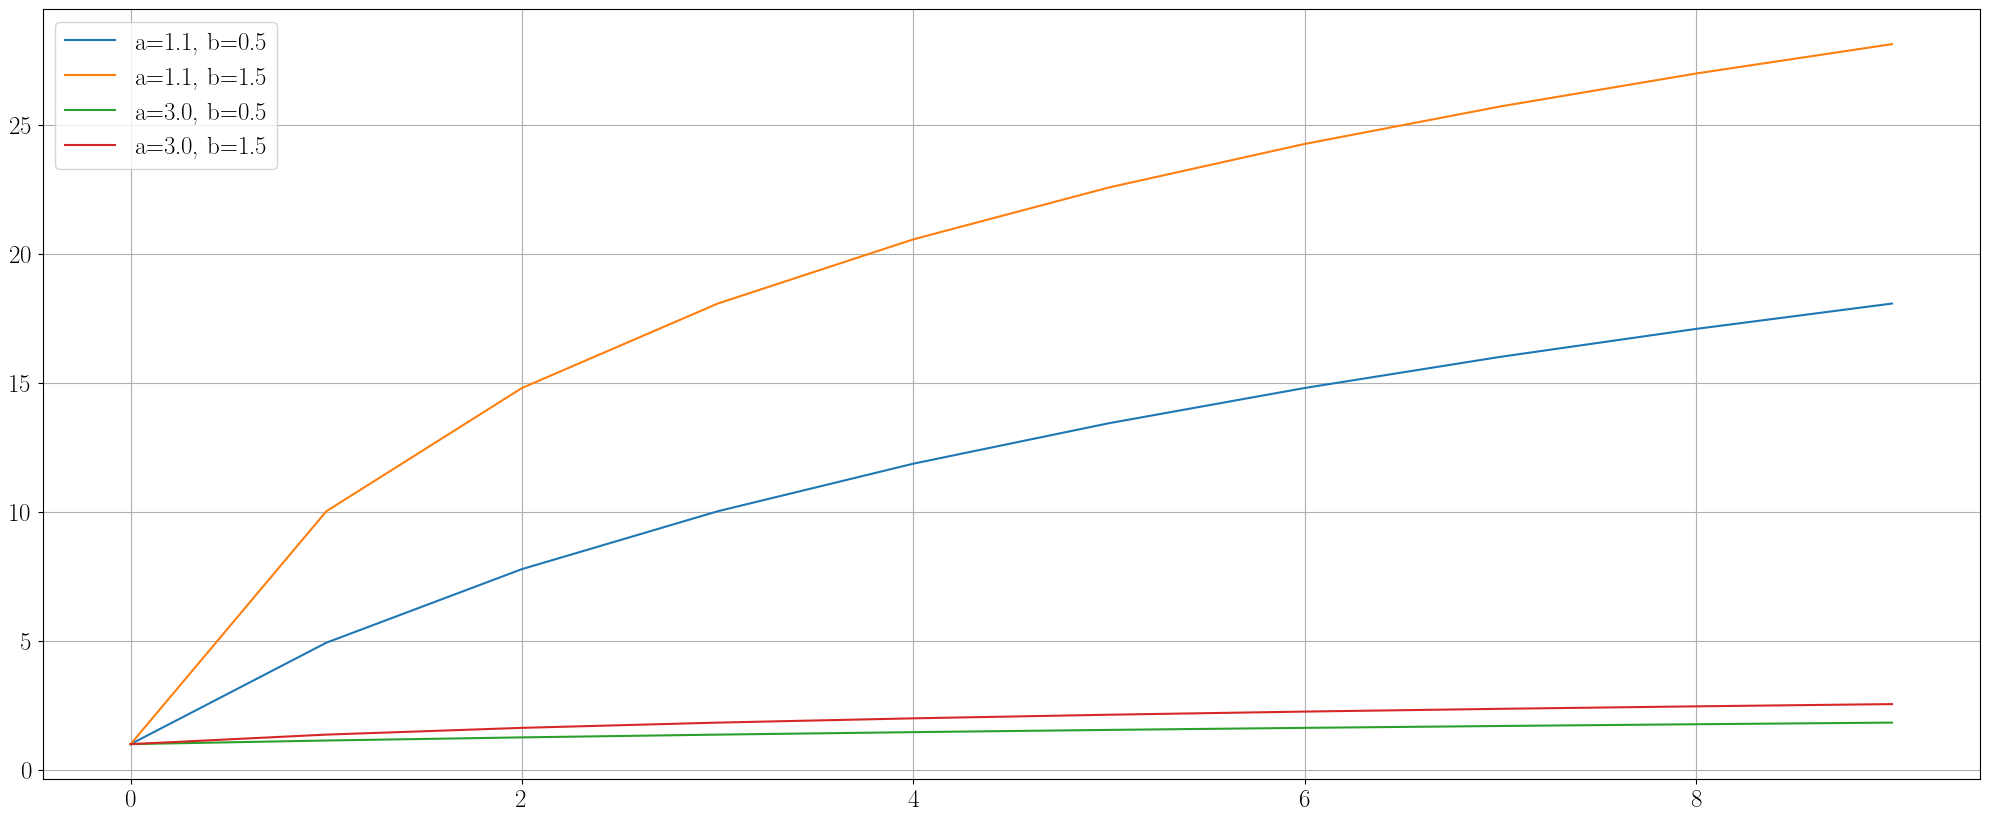

In [5]:
a_list = [1.1, 3.]
b_list = [.5, 1.5]
d = 10
x = np.array([i for i in range(d)])
for a in a_list :
    for b in b_list :
        plt.plot(x, np.log(a + b*x) / np.log(a + b*x[0]), label=f'a={a}, b={b}')
plt.legend(); plt.grid()

# Performance Comparison of Computing Smolyak Coefficients from Sparse or Dense Multi-Index Sets 

In [6]:
d = 345
k = np.array([(i + 2) ** (-2) for i in range(d)])
k = np.log(1 / k / 0.001)
k /= k[0]
t = 3

isparse = indexset_sparse(lambda j: k[j], t, cutoff=d)
idense = indexset_dense(k, t)

In [8]:
%%prun -s time -l 20
for nu in isparse :
    c = smolyak_coefficient_zeta_sparse(lambda j: k[j], t, nu=nu, cutoff=d)

         28767 function calls (25414 primitive calls) in 0.029 seconds

   Ordered by: internal time
   List reduced from 44 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 4172/822    0.009    0.000    0.019    0.000 indices.py:53(abs_e_sparse)
     1644    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     1644    0.004    0.000    0.011    0.000 fromnumeric.py:69(_wrapreduction)
    11368    0.002    0.000    0.002    0.000 <string>:2(<lambda>)
     1644    0.002    0.000    0.014    0.000 fromnumeric.py:2338(sum)
  823/822    0.002    0.000    0.027    0.000 indices.py:70(smolyak_coefficient_zeta_sparse)
     1645    0.001    0.000    0.001    0.000 {built-in method builtins.getattr}
      2/1    0.001    0.000    0.019    0.019 <string>:1(<module>)
     1644    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
     1644    0.000    0.000    0.000    0.000 {method 'items' of '

In [9]:
%%prun -s time -l 20
for nu in idense :
    c = smolyak_coefficient_zeta_dense(k, t, nu=nu)

         2397051 function calls (1606266 primitive calls) in 10.924 seconds

   Ordered by: internal time
   List reduced from 115 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
791604/822   10.676    0.000   10.824    0.013 indices.py:21(unitball)
   791612    0.088    0.000    0.088    0.000 {built-in method builtins.len}
   789037    0.078    0.000    0.078    0.000 multiarray.py:761(dot)
     3389    0.048    0.000    0.048    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     3389    0.010    0.000    0.064    0.000 fromnumeric.py:69(_wrapreduction)
  823/822    0.008    0.000   10.922    0.013 indices.py:32(smolyak_coefficient_zeta_dense)
     3389    0.006    0.000    0.071    0.000 fromnumeric.py:2338(sum)
     3390    0.005    0.000    0.005    0.000 {built-in method builtins.getattr}
     3398    0.001    0.000    0.001    0.000 {built-in method builtins.isinstance}
      2/1    0.001    0.001    6.503    6.503 <strin